In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# a. Import data & info()
nycgreen = pd.read_parquet(r"C:\Users\manis\Downloads\green_tripdata_2023-09.parquet")
nycgreen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65471 entries, 0 to 65470
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               65471 non-null  int32         
 1   lpep_pickup_datetime   65471 non-null  datetime64[us]
 2   lpep_dropoff_datetime  65471 non-null  datetime64[us]
 3   store_and_fwd_flag     60856 non-null  object        
 4   RatecodeID             60856 non-null  float64       
 5   PULocationID           65471 non-null  int32         
 6   DOLocationID           65471 non-null  int32         
 7   passenger_count        60856 non-null  float64       
 8   trip_distance          65471 non-null  float64       
 9   fare_amount            65471 non-null  float64       
 10  extra                  65471 non-null  float64       
 11  mta_tax                65471 non-null  float64       
 12  tip_amount             65471 non-null  float64       
 13  t

In [7]:
# b. Drop ehail_fee column
nycgreen = nycgreen.drop("ehail_fee", axis=1)

In [8]:
# c. Calculate trip_duration
nycgreen["trip_duration"] = (nycgreen["lpep_dropoff_datetime"] - nycgreen["lpep_pickup_datetime"]).dt.total_seconds() / 60

In [9]:
# d. Extract weekday and value_counts()
nycgreen["weekday"] = nycgreen["lpep_dropoff_datetime"].dt.day_name()
print(nycgreen["weekday"].value_counts())

weekday
Friday       11439
Thursday     10132
Wednesday     9755
Saturday      9359
Tuesday       9355
Monday        8432
Sunday        6999
Name: count, dtype: int64


In [10]:
# e. Extract hour and value_counts()
nycgreen["hourofday"] = nycgreen["lpep_dropoff_datetime"].dt.hour
print(nycgreen["hourofday"].value_counts())

hourofday
18    5156
17    4991
16    4619
15    4260
19    4059
14    3907
12    3697
10    3440
11    3432
13    3431
20    3350
9     3342
21    2941
8     2669
22    2560
7     2165
23    2023
0     1671
1      998
6      763
2      726
3      477
4      439
5      355
Name: count, dtype: int64


In [11]:
# f. Missing Values Imputation
for col in nycgreen.columns:
    if nycgreen[col].isnull().any():
        if nycgreen[col].dtype == 'object':
            nycgreen[col] = nycgreen[col].fillna(nycgreen[col].mode()[0])
        else:
            nycgreen[col] = nycgreen[col].fillna(nycgreen[col].median())

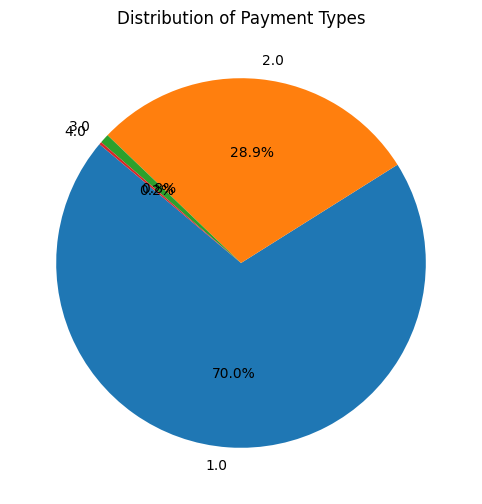

In [12]:
# g. Pie diagram of payment_type
payment_type_counts = nycgreen['payment_type'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(payment_type_counts, labels=payment_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Payment Types')
plt.show()

In [13]:
# h. Groupby() of average total_amount & weekday
weekday_avg_total = nycgreen.groupby('weekday')['total_amount'].mean()
print("Average total_amount by weekday:\n", weekday_avg_total)

Average total_amount by weekday:
 weekday
Friday       26.815751
Monday       26.317186
Saturday     27.188737
Sunday       27.624039
Thursday     26.090373
Tuesday      25.922452
Wednesday    26.177739
Name: total_amount, dtype: float64


In [14]:
# i. Groupby() of average total_amount & payment_type
payment_avg_total = nycgreen.groupby('payment_type')['total_amount'].mean()
print("Average total_amount by payment type:\n", payment_avg_total)

Average total_amount by payment type:
 payment_type
1.0    28.515787
2.0    22.560460
3.0     5.816955
4.0     5.481333
Name: total_amount, dtype: float64


In [15]:
# j. Test null average total_amount of different trip_type is identical

from scipy.stats import ttest_ind
trip_type_groups = nycgreen.groupby('trip_type')['total_amount'].apply(list)
if len(trip_type_groups) >= 2:
    t_stat, p_value = ttest_ind(trip_type_groups[1], trip_type_groups[2], equal_var=False, nan_policy='omit')
    print(f"T-test for trip_type:\nT-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")
else:
    print("Not enough trip types to perform t-test.")

T-test for trip_type:
T-statistic = -32.515, p-value = 0.000


In [16]:
# k. Test null average total_amount of different weekday is identical
weekday_groups = nycgreen.groupby('weekday')['total_amount'].apply(list)
if len(weekday_groups) >= 2:
    t_stat_weekday, p_value_weekday = ttest_ind(weekday_groups.iloc[0], weekday_groups.iloc[1], equal_var=False, nan_policy='omit')
    print(f"T-test for weekday:\nT-statistic = {t_stat_weekday:.3f}, p-value = {p_value_weekday:.3f}")
else:
    print("Not enough weekdays to perform t-test.")

T-test for weekday:
T-statistic = 1.325, p-value = 0.185


In [17]:
# l. Test null no association between trip_type and payment_type
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(nycgreen['trip_type'], nycgreen['payment_type'])
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square test for trip_type and payment_type:\nChi2 = {chi2:.3f}, p-value = {p_value_chi2:.3f}")

Chi-square test for trip_type and payment_type:
Chi2 = 219.317, p-value = 0.000


In [18]:
# m. Correlation analysis of numeric cols
numeric_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'trip_duration', 'passenger_count']


In [19]:
# n. Object variables
object_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday']

In [20]:
# Drop original datetime columns
nycgreen = nycgreen.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime'], axis=1)

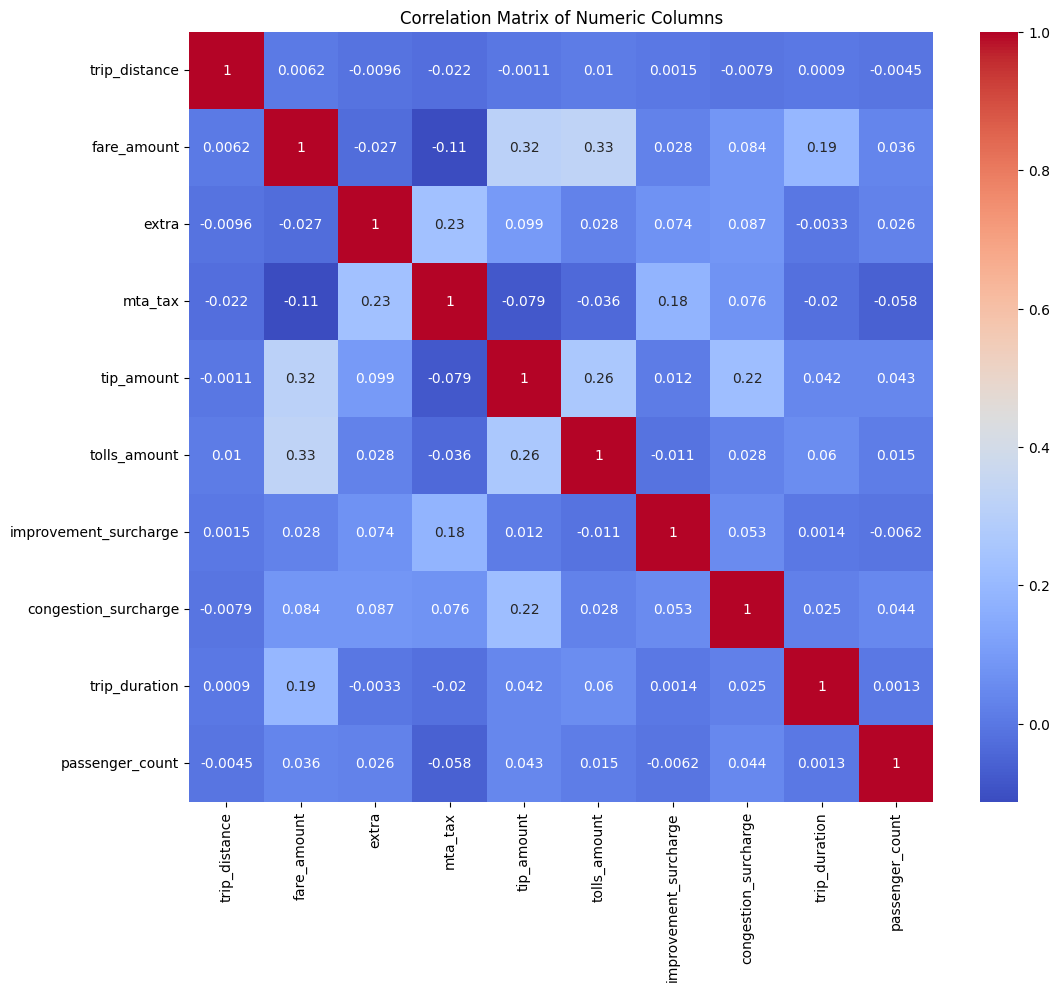

In [21]:
# o. Correlation analysis of numeric cols
import seaborn as sns
correlation_matrix = nycgreen[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

In [22]:
# p. Dummy encode object cols
from sklearn.preprocessing import LabelEncoder
# 14. Object variables
object_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each object column
for col in object_cols:
    nycgreen[col] = label_encoder.fit_transform(nycgreen[col].astype(str))

In [23]:
nycgreen.shape

(65471, 20)

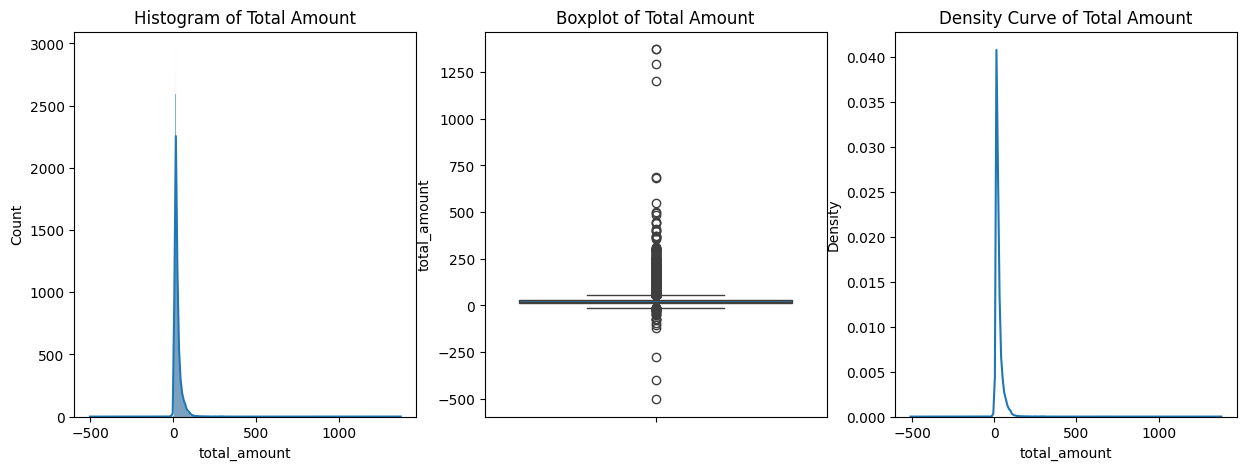

In [24]:
# q. Dependent Variable Analysis (total_amount)
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 3, 1)
sns.histplot(nycgreen['total_amount'], kde=True)
plt.title('Histogram of Total Amount')

# Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=nycgreen['total_amount'])
plt.title('Boxplot of Total Amount')

# Density Curve
plt.subplot(1, 3, 3)
sns.kdeplot(nycgreen['total_amount'])
plt.title('Density Curve of Total Amount')

plt.show()

In [25]:
# Encoding
df_encoded = pd.get_dummies(nycgreen, columns=['store_and_fwd_flag', 'weekday'], drop_first=True)

# Modeling
X = df_encoded.drop(['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
                     'VendorID', 'PULocationID', 'DOLocationID'], axis=1, errors='ignore')
y = df_encoded['total_amount']

In [26]:
# r. Model Building
from sklearn.model_selection import train_test_split
X = nycgreen.drop('total_amount', axis=1)
y = nycgreen['total_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Multiple Linear Regression
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_mlr = mlr.predict(X_test)
mlr.score(X_test, y_test)


0.9995834333116577

In [28]:
#  Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=8,random_state=42,)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt.score(X_test, y_test)

0.9849638392471368

In [29]:
#  Random Forest with 100 trees
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf.score(X_test, y_test)

0.994879162495858

In [30]:
#  Gradient Boosting with 100 trees
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
gb.score(X_test,y_test)

0.9973343082871777

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# Store model names, predictions, and actual scores in a list of tuples
models = [
    ("Gradient Boosting", y_test, y_pred_gb),
    ("Random Forest", y_test, y_pred_rf),
    ("Decision Tree", y_test, y_pred_dt),
    ("Multiple Linear Regression", y_test, y_pred_mlr),
]

# Print MSE and R² score for each model
for name, y_true, y_pred in models:
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n\tR2 Score: {r2:.4f}\n\tMean Squared Error: {mse:.4f}\n")


Gradient Boosting:
	R2 Score: 0.9973
	Mean Squared Error: 1.6256

Random Forest:
	R2 Score: 0.9949
	Mean Squared Error: 3.1229

Decision Tree:
	R2 Score: 0.9850
	Mean Squared Error: 9.1695

Multiple Linear Regression:
	R2 Score: 0.9996
	Mean Squared Error: 0.2540

